# Cordyceps Pandemic Zombies

**Spoiler Warnings for The Last Of Us!!!**

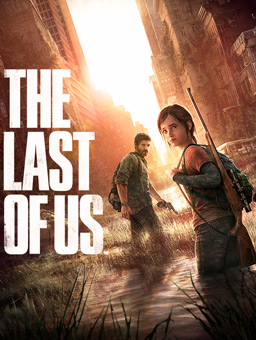




Suppose you have a pandemic of cordyceps fungal infection as in the game and show "The Last of Us". If someone is infected by the cordyceps fungus, they become a zombie who feeds on other people, and infects them, creating more zombies. There is a single person, Ellie Williams, who is immune to cordyceps infection. If you are a fan of the show, we will be diverging from canon now. Suppose that a group of people (the "Fireflies") has benignly developed a **cure** for cordyceps, but not a **vaccine**, using Ellie's blood. If the treatment is administered, the person in question is no longer infected. However, they can be re-infected by being bitten again. This means Ellie herself is the best person to administer the vaccine, so she will be wandering around aimlessly administering the vaccine to nearby people. She has an infinite supply of vaccine.  


We will consider `n_walker` random walkers in 2 dimensions that each take `n_steps` steps. At each step, the walkers can move `d` units in either x or y. The walkers are confined to a single 1x1 room with cyclic boundary conditions in x and y (so, the walkers wrap around if they wander off the edge). There is a configurable initial number of infected zombies, `n_infected`.  There is always one person immune (Ellie), but healthy people can be infected by zombies and cured by Ellie. 

The code below assumes that there is zero rate of transmission from the infected individuals (i.e., passive zombies). The animation shows the paths of the walkers. The healthy individuals show up as blue dots. The zombies show up as red dots. Ellie is a green dot. 



# Problem 1: 

### Part a (15 points)

The "infection rate" `P_i` and an "infection distance" `d_i` are given in the code, where any walkers that are within the infection distance `d_i` to an infected individual have a probability `P_i` to be infected. The infected will then then infect others in later time steps. The animation should reflect the changes. (Hint: This can't be vectorized, so you have to use for loops for the time iteration, but use a vectorized implementation using array programming for each time step). Assume: `n_walkers=100`, `n_steps=100`, `n_infected=4`, `d=0.01`, `P_i = 0.1`, and `d_i=0.1`. 

### Part b (10 points): 

Plot the number of total infections in the sample as a function of time step for `P_i = 0.1, 0.2, 0.3`, and for `d_i = 0.01, 0.02, 0.03`. Assume: `n_walkers=100`, `n_steps=1000`, `n_infected=4`, `dx=0.01`.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy 

In [ ]:
np.random.seed(12345) #NOTE: This sounds like the combination an idiot has on their luggage. 

### Run the walkers

In [ ]:
class Zombies(object):
    def __init__(self, n_walkers, n_steps, n_infected, d, P_i, d_i, P_c, d_c):
        self.dims = 2
        self.n_walkers = n_walkers
        self.n_steps = n_steps
        self.n_infected = n_infected
        self.t = np.arange(n_steps)
        # Walkers can go in + direction, - direction, or stay still
        self.d = d
        self.P_i = P_i
        self.d_i = d_i
        self.step_set = np.array([-1, 0, 1]) * self.d
        # The shape is for "n_walkers" in "dims" dimensions taking "n_steps".
        # So, in 1d if there are 10 walkers making 100 steps each,
        # it will be (10, 2, 100)
        self.step_shape = (self.n_walkers,self.n_steps,self.dims)
        self.ellie_step_shape = (1, self.n_steps, self.dims )
        self.init_positions = np.random.uniform( 0.0, 1.0, size=(self.n_walkers, self.dims) )
        self.init_ellie_positions = np.random.uniform(0.0, 1.0, size=(1,self.dims))
        self.init_infected = np.zeros( self.n_walkers, dtype=int )
        self.init_infected[0:self.n_infected] = 1
        np.random.shuffle( self.init_infected )
        self.positions = None
        self.ellie_positions = None
        self.infected = np.zeros( shape=(self.n_walkers,self.n_steps), dtype=bool)
        self.infected[:,:] = self.init_infected[:,np.newaxis]
        self.ii = np.arange(self.n_walkers)
        self.jj = np.arange(self.n_infected)
        self.tot_infected = []
        
    def walk(self):
        # These are the steps at each stage        
        self.steps = np.random.choice(a=self.step_set, size=self.step_shape)        
        self.ellie_steps = np.random.choice(a=self.step_set, size=self.ellie_step_shape)
            
        # Now we add up the steps for each walker to get the x positions
        self.positions = (self.init_positions[:,np.newaxis,:] + self.steps.cumsum(axis=2)) % 1.0
        self.ellie_positions = (self.init_ellie_positions[:,np.newaxis,:] + self.ellie_steps.cumsum(axis=2)) % 1.0
        

### Run the simulation without the plot

This will also be used in Problem 3. 

In [ ]:
zombies=Zombies(n_walkers=1000,n_steps=10,n_infected=100,d=0.1,P_i=0.01,d_i=0.1,P_c=1.0,d_c=0.1 )
zombies.walk()

In [ ]:
if False: ## Change to True to print these
    print("All positions: ", zombies.positions)
    print("Positions of infected", zombies.positions[zombies.infected])
    print("Ellie's positions", zombies.ellie_positions)

### Draw the walkers

In [ ]:
from matplotlib import animation, rc, colors
from IPython.display import HTML
rc('animation', html='html5')

In [ ]:
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, n_walkers=100, n_steps=10, n_infected=4, d=0.1, P_i = 0.04, d_i=0.1, P_c=1.0,d_c=0.1):
        self.stream = self.data_stream()
        self.zombies=Zombies(n_walkers=n_walkers,n_steps=n_steps,n_infected=n_infected,
                             d=d,P_i=P_i,d_i=d_i,P_c=P_c,d_c=d_c)
        self.zombies.walk()
        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=100, frames=n_steps,
                                           init_func=self.setup_plot, blit=False)
        thecolors = [(0, 0, 1), (1, 0, 0), (0, 1, 0) ]  # B -> R -> G
        self.cmap = colors.LinearSegmentedColormap.from_list("mine", thecolors, N=3)
        

    def setup_plot(self):

        """Initial drawing of the scatter plot."""
        data = next(self.stream)
        self.scat = self.ax.scatter(data[0], data[1], animated=True, c=data[2],
                                   cmap=self.cmap, vmin=0, vmax=2)
        self.ax.axis([0, 1, 0, 1])

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    

    def data_stream(self):
        i = 0
        while True:
            if i >= self.zombies.n_steps:
                i = 0
            x = np.append( self.zombies.positions[:,i,0], self.zombies.ellie_positions[0,i,0] )
            y = np.append( self.zombies.positions[:,i,1], self.zombies.ellie_positions[0,i,1] )
            c = np.append( self.zombies.infected[:,i], 2 )
            i += 1
            yield np.c_[x,y,c]

    def update(self, i):
        """Update the scatter plot."""    
        data = next(self.stream)
        
        # Set x and y data...
        self.scat.set_offsets(data[:,:2])
        self.scat.set_array(data[:,2])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,



### FOR PROBLEM 1: Animate with `P_c = 0` to demonstrate the infection

In [ ]:
#%matplotlib notebook
a = AnimatedScatter(n_walkers=10, n_steps=10, n_infected=4, d=0.05, P_i = 0.1, d_i=0.1, P_c=0.0, d_c=0.1)
HTML(a.ani.to_html5_video())

---

---

# Problem 2

## Part a (15 points): 

Implement a "cure rate rate" `P_c` and a "cure distance" `d_c` where any walkers that are within the cure distance `d_c` to Ellie have a probability `P_c` to be cured. They cannot cure others in later steps, since it is too risky for them to get near infected people. The animation should reflect the changes. (Again: This can't be vectorized, so you have to use for loops). Assume: `n_walkers=100`, `n_steps=100`, `n_infected=4`, `d=0.01`, `P_i = 0.1`, `d_i=0.03`, `P_c = 1.0`, `d_c = 0.05`. 

## Part b (10 points): 

Plot the number of total infections in the sample as a function of time step for `P_i = 0.1, 0.2, 0.3`, and for `d_i = 0.01, 0.02, 0.03`. Assume: `n_walkers=100`, `n_steps=1000`, `n_infected=4`, `dx=0.01`.


### FOR PROBLEM 2: Animate with `P_c = 1` to demonstrate the cure

In [ ]:
a = AnimatedScatter(n_walkers=10, n_steps=10, n_infected=4, d=0.05, P_i = 0.1, d_i=0.1, P_c=1.0, d_c=0.1)
HTML(a.ani.to_html5_video())

---

---

## **Problem 3 (25 points)**: 

Suppose now that you'd like Ellie to be a little smarter. In this problem, let the simulation run for 10 iterations with Ellie inactive. Compute a Voronoi tesselation of the 10th frame (i.e. frame = 9) into 5 groups. Plot the tesselation as is done in the example code for Voronoi tesselation, and list the number of healthy and infected people in each of the 5 groups. The function to make a Voronoi tesselation is copied from the example code. (Correct code: 15 points. Plots: 10 points). 


In [ ]:
def make_voronoi(points, ncentroids=3,eps=1e-3, ndim=2):
    centroids = np.random.rand( ncentroids, ndim )
    closest_centroid = None
    deltamax = 10000.
    ii = np.arange(len(points))
    jj = np.arange(ncentroids)
    i,j = np.meshgrid(ii,jj)
    while deltamax > eps: 
        print("iterating: ", deltamax  ) 
        old_centroids = copy.copy(centroids)
        deltavals = np.sqrt(( points[i] - centroids[j] )**2)
        distances = np.linalg.norm( deltavals, axis=2 )
        closest_centroid = np.argmin(distances, axis=0)
        centroids = np.array([points[closest_centroid==k].mean(axis=0) for k in range(centroids.shape[0])])
        deltamax = np.max( old_centroids - centroids)
    return centroids, closest_centroid

In [ ]:
## Your code goes here

---

---

# Problem 4a (25 points), GRAD STUDENTS ONLY: 


Implement Ellie's plan from Problem 3 in the simulation and animation. Add a boolean variable to the `Zombies` class that is `goodStrat` that defaults to `False` so the previous problems still work. If true, Every 10th frame (i.e. frame = 9, 19, 29, etc), Ellie should recompute the Voronoi tesselation of the infected people. Instead of randomly wandering around, she will move directly toward the Voronoi tesselation with the largest number of infected people. Compute the distance to the centroids and have her walk directly toward the centroid with the largest number of infected people with $\sqrt{dx^2 + dy^2} = 0.01$. Print out the centroids and the number of infected within them, and print her path as she goes. She will continue to administer the cure along the way to other infected people within `d_c` but will not deviate from her path. **DO NOT CHANGE THE BEHAVIOR OF PREVIOUS PROBLEMS SO EXECUTING THE NOTEBOOK WORKS FROM SCRATCH OR YOU WILL LOSE 15 POINTS ON THIS PROBLEM. IT SHOULD BE ENABLED ONLY WHEN `goodStrat==True`.**

(Correct implemenation of the Voronoi tesselation: 10 points. Correct implementation of her path: 15 points). 

In [ ]:
#%matplotlib notebook
a = AnimatedScatter(n_walkers=10, n_steps=10, n_infected=4, d=0.05, P_i = 0.1, d_i=0.1, P_c=1.0, d_c=0.1, goodStrat=True)
HTML(a.ani.to_html5_video())